In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import PIL
import numpy as np
import matplotlib.pyplot as plt

from utils.ShipDataset import get_ship_dataset, load_image, ShipDataset
from utils.Training import TrainingHelper, PlotReporter, ConsoleReporter

### Ship Localization ###

This notebook uses models and code from SmallConvNet.ipynb. For more detailed information read that notebook first. 


In this notebook we prupose a model that locates shipes on a whole satalite image. First train a small network to classify 80x80 segments.
Then we move this kernel across the whole satlite iamge and decide for every region weather there is a ship present or not. This way the localization network outputs a rough heatmeat of possible ship locations.


In [2]:
n_samples = 10000
# low the maximum downscale augmentation value to allow a greater variance in ship sizes and scales
ShipDataset.downscale = 0.65

train_dataset, valid_dataset = get_ship_dataset("./dataset/class", n_samples, validation=0.2)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)

### CNN
Using convolution layers instead of fully connected layers in the final layer of the model. 
This way we can increase the input demensions of the network and get a heatmap as output.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d( 3,   4, 3),
            nn.Conv2d( 4,   8, 3),
            nn.Conv2d( 8,  16, 3),
            nn.Conv2d( 16, 32, 3),
        ])
        self.fcs = nn.ModuleList([
            nn.Conv2d(32, 1, 3)   
        ])

    def forward(self, x):
        for conv in self.convs:
            x = nn.MaxPool2d(2,2)(F.relu(conv(x)))
        
        for fc in self.fcs:
            x = torch.sigmoid(fc(x))
            
        return x.view(-1, 1)
        
    def forward_loc(self, x):
        with torch.no_grad():
            for i,  conv in enumerate(self.convs):
                x = F.relu(conv(x))
                x = nn.MaxPool2d(2,2)(x)

            for fc in self.fcs:
                x = torch.sigmoid(fc(x))

            return x

net = Net()

In [4]:
training = TrainingHelper(net, nn.BCELoss(), optim.Adam(net.parameters(), lr=0.001))
training.reporter = PlotReporter(figsize=(15,5))
#training.reporter = ConsoleReporter()

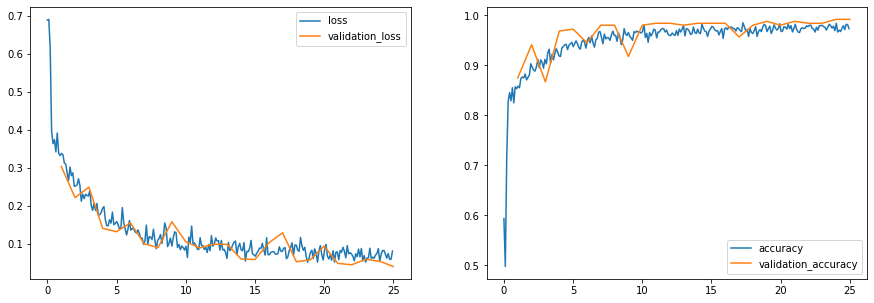

In [21]:
# train for n_gen generations
n_gen = 25
training.fit(n_gen,train_loader,valid_loader)

In [22]:
img_loc = load_image("./dataset/loc/sfbay_2.png")

In [23]:
#resize the image so that the ships are approximately 80px long
scale_f = 0.9
img_loc = img_loc.resize((int(img_loc.size[0]*scale_f), int(img_loc.size[1]*scale_f)), PIL.Image.BILINEAR)

(2772, 1437)


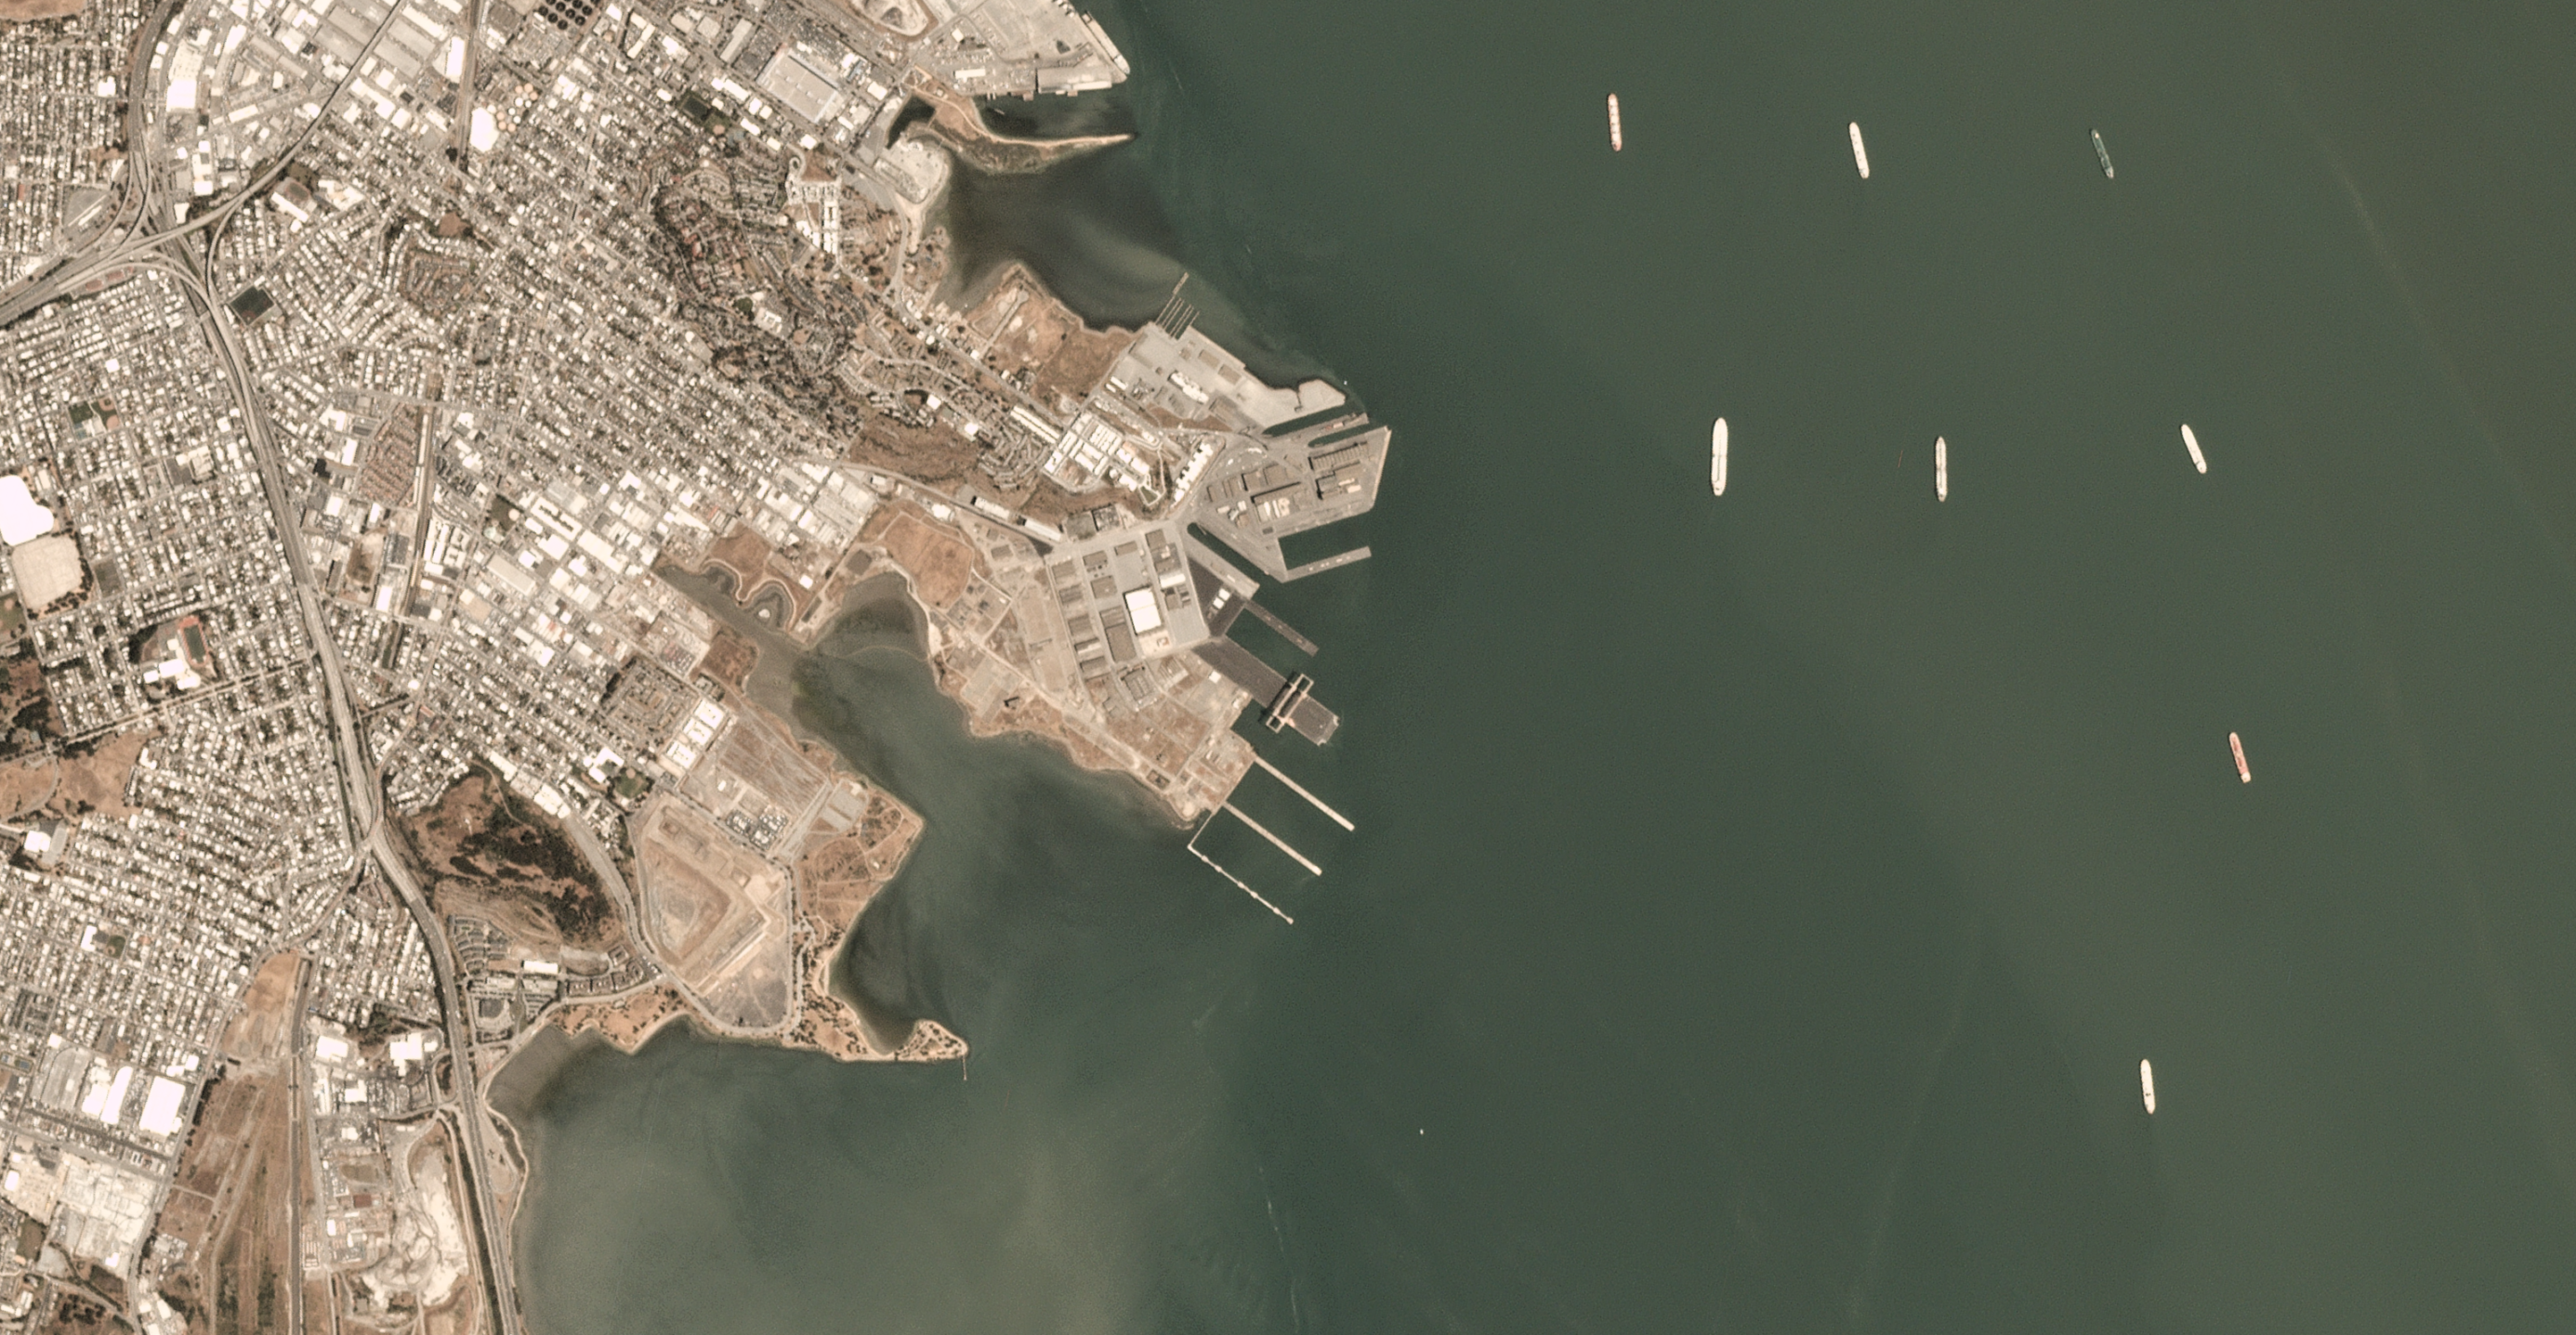

In [24]:
print(img_loc.size)
img_loc

In [25]:
input_loc = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])(img_loc).unsqueeze(0)

In [34]:
heat_map = net.forward_loc(input_loc)[0,0].numpy()

In [35]:
# apply threshold - set every value below th to 0
th = 0.7
heat_map[heat_map < th] = 0 

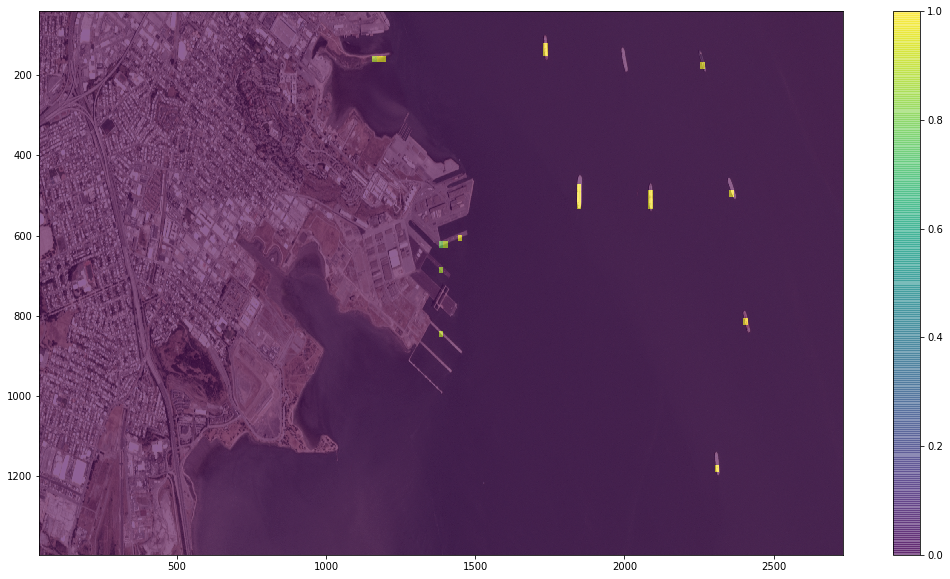

In [36]:
plt.figure(figsize=(18,10))
plt.imshow(img_loc)
plt.imshow(heat_map, cmap=plt.cm.viridis, alpha=0.6, vmin=0, vmax=1,aspect="auto", extent=(40, img_loc.size[0]-40,img_loc.size[1]-40, 40))#, interpolation='bilinear' )
plt.colorbar()